In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
from lifelines.datasets import load_rossi
rossi = load_rossi() 

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-05-03 22:21:14 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.09      1.10      0.03            0.04            0.15                1.04                1.16

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

In [4]:
from lifelines.utils.concordance import concordance_index
from lifelines.utils import normalize

X = rossi.copy()
T = X.pop('week')
E = X.pop('arrest')

beta = cph.params_.values
X_norm = normalize(X.values, cph._norm_mean.values, 1)
partial_hazards = np.exp(np.dot(X_norm, beta))

concordance_index(
    event_times = T.values, 
    predicted_scores = -partial_hazards, 
    event_observed = E.values
)

0.6403292470997135

<Axes: xlabel='duration'>

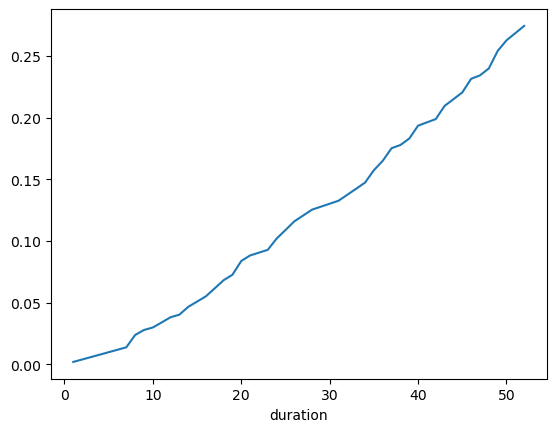

In [5]:
def compute_baseline_hazards(partial_hazards, T, E):
    # Here we are computing when expg when there are no events.
    #   Could be made faster, by only computing when there are events.
    expg = partial_hazards
    df = pd.DataFrame(dict(
        expg=expg,
        event=E,
        duration=T,
    ))
    return (df
            .groupby('duration')
            .agg('sum')
            .sort_index(ascending=False)
            .assign(expg=lambda x: x.expg.cumsum())
            .pipe(lambda x: x.event/x.expg)
            .fillna(0.)
            .iloc[::-1]
            .rename('baseline_hazards'))

def compute_baselime_cumulative_hazards(baseline_hazards):
    return baseline_hazards.cumsum()

cum_base_haz = compute_baselime_cumulative_hazards(compute_baseline_hazards(partial_hazards, T, E))
cum_base_haz.plot()

In [6]:
cph.predict_partial_hazard(X.iloc[0:5])

0    1.219126
1    3.230250
2    3.031058
3    0.487712
4    1.214025
dtype: float64

<Axes: >

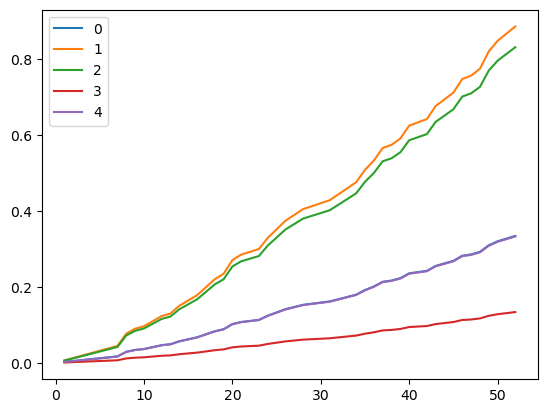

In [7]:
from lifelines.utils import interpolate_at_times

def predict_cumulative_hazard_lifelines(partial_hazards, baseline_cumulative_hazard, times) -> pd.DataFrame:
    n = len(partial_hazards)
    v = partial_hazards[0:5]

    times_to_evaluate_at = np.tile(times, (n, 1))
    c_0 = interpolate_at_times(baseline_cumulative_hazard, times_to_evaluate_at).T

    cumulative_hazard_ = pd.DataFrame(c_0 * v, columns=range(n), index=times)

    return cumulative_hazard_

predict_cumulative_hazard_lifelines(cph.predict_partial_hazard(X.iloc[0:5]).values, cph.baseline_cumulative_hazard_, cph.timeline).plot()

<Axes: >

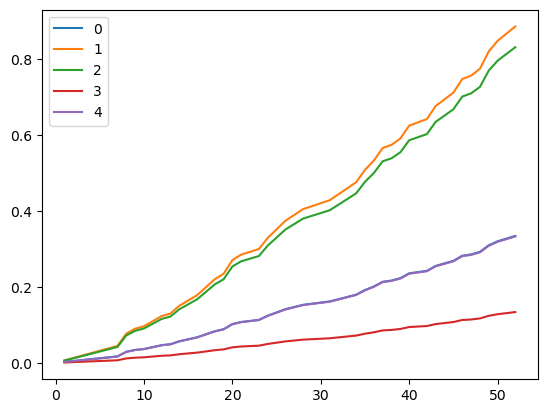

In [8]:
predict_cumulative_hazard_lifelines(partial_hazards[0:5], cum_base_haz, cph.timeline).plot()

In [9]:
from pycox.evaluation.metrics import partial_log_likelihood_ph

partial_log_likelihood_ph(
    log_partial_hazards=partial_hazards,
    durations=T,
    events=E,
    mean=True
)

-5.985998659506427

In [10]:
cph.score(rossi, scoring_method="log_likelihood")

-1.5248788413103833

In [26]:
def deepsurv_loss_ez(y_pred, y_true, E):
    loss = 0
    n = len(y_true)
    for i in range(n): 
        if E[i] != 1: 
            continue 
        inner_sum = 0 
        for j in range(n): 
            if y_true[j] >= y_true[i]:
                inner_sum += np.exp(y_pred[j] - y_pred[i])

        loss += np.log(inner_sum)
    loss = loss/n
    loss

def deepsurv_loss_hard(y_pred, y_true, E, eps = 1e-7): 
    df = pd.DataFrame(dict(
        y_pred=y_pred,
        y_true=y_true,
        E=E
    )).sort_values('y_true', ascending=False)
    
    events = df.E 
    log_h = df.y_pred 
    gamma = log_h.max() 
    log_cumsum_h = np.log(np.exp(log_h.sub(gamma)).cumsum(0).add(eps)).add(gamma)
    return - log_h.sub(log_cumsum_h).mul(events).sum() / events.sum()

deepsurv_loss_hard(partial_hazards, T, E)


5.946830670658149

In [121]:
df = pd.DataFrame(dict(duration=T, event=E, lph=partial_hazards))
pll = (df
    .sort_values('duration', ascending=False)
    .assign(cum_ph=(lambda x: x['lph']
                        .pipe(np.exp)
                        .cumsum()
                        .groupby(x['duration'])
                        .transform('max')))
    .loc[lambda x: x['event'] == 1]
    .assign(pll=lambda x: x['lph'] - np.log(x['cum_ph']))
    ['pll'])
pll.mean()


-5.985998659506427

In [110]:
def partial_log_likelihood_lifelines(partial_hazards: np.array, T: pd.Series, E: pd.Series):
    ordering = np.lexsort((E, T))
    T = T.values[ordering]
    E = E.values[ordering]
    partial_hazards = partial_hazards[ordering]
    n = len(E)

    log_lik = 0

    # Init risk and tie sums to zero
    x_death_sum = 0
    risk_phi, tie_phi = 0, 0

    # Init number of ties and weights
    weight_count = 0.0
    tied_death_counts = 0

    # Iterate backwards to utilize recursive relationship
    for i in range(n - 1, -1, -1):
        # Doing it like this to preserve shape
        ei = E[i]

        # Calculate phi values
        phi_i = partial_hazards[i]
        
        # Calculate sums of Risk set
        risk_phi = risk_phi + phi_i

        # Calculate sums of Ties, if this is an event
        if ei:
            x_death_sum = x_death_sum + np.log(partial_hazards[i])
            tie_phi = tie_phi + phi_i

            # Keep track of count
            tied_death_counts += 1
            weight_count += 1

        # There are no more ties/members of the risk set and there are uncensored with the current time
        if not (i > 0 and T[i] == T[i - 1]) and tied_death_counts != 0:
            # There was at least one event and no more ties remain. Time to sum.
            # This code is near identical to the _batch algorithm below. In fact, see _batch for comments.
            weighted_average = weight_count / tied_death_counts

            if tied_death_counts > 1:
                increasing_proportion = np.arange(tied_death_counts) / tied_death_counts
                denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
            else:
                denom = 1.0 / np.array([risk_phi])

            log_lik = log_lik + x_death_sum + weighted_average * np.log(denom).sum()
            
            # reset tie values
            tied_death_counts = 0
            weight_count = 0.0
            x_death_sum = 0
            tie_phi = 0

    return log_lik/n

partial_log_likelihood_lifelines(partial_hazards, T, E)

-1.5248788413103833